In [322]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import ast
from sklearn.base import BaseEstimator, TransformerMixin
from nltk import TweetTokenizer

In [17]:
X_train = pd.read_csv(r'D:\Machine Learning\Datasets\ted-talks\X_train.csv')
X_test = pd.read_csv(r'D:\Machine Learning\Datasets\ted-talks\X_test.csv')
y_train = pd.read_csv(r'D:\Machine Learning\Datasets\ted-talks\y_train.csv', header=None)
y_test = pd.read_csv(r'D:\Machine Learning\Datasets\ted-talks\y_test.csv', header=None)

In [9]:
X_train.shape

(2040, 18)

In [10]:
X_test.shape

(510, 18)

In [11]:
y_train.shape

(2040, 1)

In [12]:
y_test.shape

(510, 1)

# Feature engineering with dates 

In [24]:
X_train['film_date_formated'] =  pd.to_datetime(X_train['film_date'],unit='s')
X_train['published_date_formated'] =  pd.to_datetime(X_train['published_date'],unit='s')
X_test['film_date_formated'] =  pd.to_datetime(X_test['film_date'],unit='s')
X_test['published_date_formated'] =  pd.to_datetime(X_test['published_date'],unit='s')

In [25]:
X_train.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,film_date_formated,published_date_formated
0,837,Michael Shermer says the human tendency to bel...,1141,TED2010,1265760000,34,Michael Shermer,Michael Shermer: The pattern behind self-decep...,1,1276507380,"[{'id': 7, 'name': 'Funny', 'count': 475}, {'i...","[{'id': 22, 'hero': 'https://pe.tedcdn.com/ima...",Skeptic,"['God', 'faith', 'neuroscience', 'psychology',...",The pattern behind self-deception,https://www.ted.com/talks/michael_shermer_the_...,2010-02-10,2010-06-14 09:23:00
1,305,Collective compassion has meant an overall dec...,1328,TED2015,1426550400,30,Gary Haugen,Gary Haugen: The hidden reason for poverty the...,1,1429542970,"[{'id': 1, 'name': 'Beautiful', 'count': 195},...","[{'id': 644, 'hero': 'https://pe.tedcdn.com/im...",Human rights attorney,"['inequality', 'poverty', 'violence']",The hidden reason for poverty the world needs ...,https://www.ted.com/talks/gary_haugen_the_hidd...,2015-03-17,2015-04-20 15:16:10
2,289,Gayla Benefield was just doing her job -- unti...,878,TEDxDanubia,1363910400,30,Margaret Heffernan,Margaret Heffernan: The dangers of willful bli...,1,1376319512,"[{'id': 3, 'name': 'Courageous', 'count': 413}...","[{'id': 1533, 'hero': 'https://pe.tedcdn.com/i...",Management thinker,"['TEDx', 'corruption', 'culture', 'global issu...",The dangers of willful blindness,https://www.ted.com/talks/margaret_heffernan_t...,2013-03-22,2013-08-12 14:58:32
3,101,We often think of bias and prejudice as rooted...,983,TEDSalon NY2014,1389744000,26,Paul Bloom,Paul Bloom: Can prejudice ever be a good thing?,1,1404399605,"[{'id': 11, 'name': 'Longwinded', 'count': 35}...","[{'id': 1198, 'hero': 'https://pe.tedcdn.com/i...",Psychologist,"['behavioral economics', 'mind', 'psychology']",Can prejudice ever be a good thing?,https://www.ted.com/talks/paul_bloom_can_preju...,2014-01-15,2014-07-03 15:00:05
4,101,"Blind river dolphins, reclusive lemurs, a parr...",5256,University of California,989971200,0,Douglas Adams,"Douglas Adams: Parrots, the universe and every...",1,1268762040,"[{'id': 22, 'name': 'Fascinating', 'count': 29...","[{'id': 635, 'hero': 'https://pe.tedcdn.com/im...","Author, satirist","['biodiversity', 'biology', 'comedy', 'humor',...","Parrots, the universe and everything",https://www.ted.com/talks/douglas_adams_parrot...,2001-05-16,2010-03-16 17:54:00


##  Publishing lag
Days passed from the talk performance to the talk publishing

In [80]:
publishing_lag = X_train.apply(lambda row: (row['film_date_formated'].date() 
                           - row['published_date_formated'].date()).days,
              axis=1)

In [81]:
max(publishing_lag)

335

In [82]:
min(publishing_lag)

-13879

In [83]:
len(publishing_lag[publishing_lag >= 0])

18

In [87]:
len(publishing_lag[publishing_lag < -1000])

125

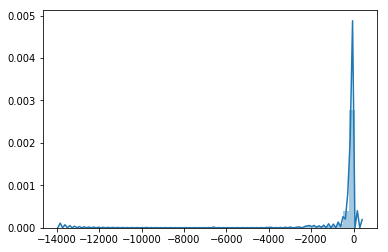

In [88]:
sns.distplot(publishing_lag)

In [89]:
publishing_lag = np.clip(publishing_lag.values, a_max=0, a_min=-1000)

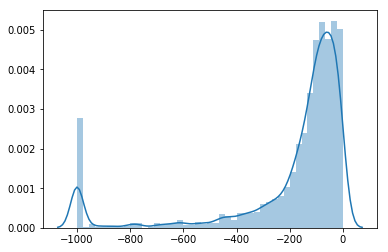

In [94]:
sns.distplot(publishing_lag)
plt.show()

In [321]:
np.corrcoef(publishing_lag, y_train.values.reshape(y_train.shape[0])) 

array([[1.        , 0.04704909],
       [0.04704909, 1.        ]])

In [95]:
def publishing_lag_calc(data, clipmax=0, clipmin=-1000):
    publishing_lag = data.apply(lambda row: (row['film_date_formated'].date() 
                           - row['published_date_formated'].date()).days,
              axis=1)
    return np.clip(publishing_lag.values, a_max=clipmax, a_min=clipmin)

## Elapsed time since 01.01.2002
With the exception of a few outliers, 2002 seems to be the first year when a published talk was filmed

In [316]:
elapsed_time = X_train.apply(lambda row: (datetime.date(2002, 1, 1) -
                                            row['film_date_formated'].date()).days 
                           , axis=1)

In [319]:
np.corrcoef(elapsed_time.values, y_train.values.reshape(y_train.shape[0])) 

array([[ 1.       , -0.0106933],
       [-0.0106933,  1.       ]])

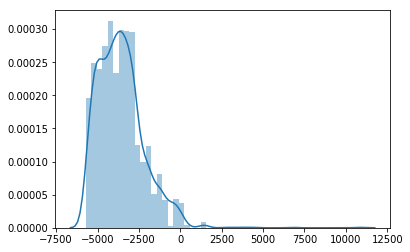

In [103]:
sns.distplot(elapsed_time)
plt.show()

In [315]:
def elapsed_time_calc(data):
    return data.apply(lambda row: (datetime.date(2002, 1, 1) -
                                            row['film_date_formated'].date()).days 
                           , axis=1).values

## Exctract year, month, day of the week as features

In [108]:
def get_year(data, column='film_date_formated'):
    return data[column].apply(lambda x: x.year).values

In [110]:
get_year(X_train.head())

array([2010, 2015, 2013, 2014, 2001], dtype=int64)

In [111]:
def get_month(data, column='film_date_formated'):
    return data[column].apply(lambda x: x.month_name()).values

In [112]:
get_month(X_train.head())

array(['February', 'March', 'March', 'January', 'May'], dtype=object)

In [113]:
def get_day(data, column='film_date_formated'):
    return data[column].apply(lambda x: x.day_name()).values

In [114]:
get_day(X_train.head())

array(['Wednesday', 'Tuesday', 'Friday', 'Wednesday', 'Wednesday'],
      dtype=object)

# Tags 

In [115]:
X_train.head().tags

0    ['God', 'faith', 'neuroscience', 'psychology',...
1                ['inequality', 'poverty', 'violence']
2    ['TEDx', 'corruption', 'culture', 'global issu...
3       ['behavioral economics', 'mind', 'psychology']
4    ['biodiversity', 'biology', 'comedy', 'humor',...
Name: tags, dtype: object

In [149]:
unique_tags = set()
for tags  in X_train.tags:
    unique_tags.update(ast.literal_eval(tags.lower()))

In [150]:
len(unique_tags)

415

In [151]:
unique_tags

{'3d printing',
 'activism',
 'addiction',
 'adventure',
 'advertising',
 'africa',
 'aging',
 'agriculture',
 'ai',
 'aids',
 'aircraft',
 'algorithm',
 'alternative energy',
 "alzheimer's",
 'ancient world',
 'animals',
 'animation',
 'anthropocene',
 'anthropology',
 'ants',
 'apes',
 'archaeology',
 'architecture',
 'art',
 'asia',
 'asteroid',
 'astrobiology',
 'astronomy',
 'atheism',
 'augmented reality',
 'autism spectrum disorder',
 'bacteria',
 'beauty',
 'bees',
 'behavioral economics',
 'big bang',
 'big problems',
 'biodiversity',
 'bioethics',
 'biology',
 'biomechanics',
 'biomimicry',
 'biosphere',
 'biotech',
 'birds',
 'blindness',
 'blockchain',
 'body language',
 'books',
 'botany',
 'brain',
 'brand',
 'brazil',
 'buddhism',
 'bullying',
 'business',
 'cancer',
 'capitalism',
 'cars',
 'cello',
 'charter for compassion',
 'chemistry',
 'children',
 'china',
 'choice',
 'christianity',
 'cities',
 'climate change',
 'cloud',
 'code',
 'cognitive science',
 'collabor

In [155]:
tags_map = {}
for tags  in X_train.tags:
    for tag in ast.literal_eval(tags.lower()):
        tags_map[tag] = tags_map.get(tag,0) + 1

In [158]:
from collections import OrderedDict

In [162]:
ordered_tags_map = OrderedDict(sorted(tags_map.items(), key=lambda item: item[1], reverse=True))
ordered_tags_map

OrderedDict([('technology', 571),
             ('science', 459),
             ('global issues', 399),
             ('culture', 393),
             ('tedx', 344),
             ('design', 323),
             ('business', 266),
             ('entertainment', 234),
             ('health', 188),
             ('innovation', 181),
             ('society', 172),
             ('art', 169),
             ('social change', 161),
             ('future', 157),
             ('humanity', 152),
             ('biology', 151),
             ('creativity', 149),
             ('communication', 149),
             ('collaboration', 140),
             ('medicine', 138),
             ('environment', 137),
             ('brain', 134),
             ('education', 127),
             ('history', 122),
             ('economics', 120),
             ('activism', 117),
             ('ted fellows', 115),
             ('community', 113),
             ('music', 112),
             ('children', 111),
             ('invention',

In [181]:
(np.array(list(ordered_tags_map.values())) > 10).sum()

210

In [251]:
class TagsOHE(BaseEstimator, TransformerMixin):
    """ //TODO
        
        Parameters
        ------------
        
        Attributes
        -----------

    """
    def __init__(self, column_name='tags', freq_greater_than=10):
        self.column_name = column_name
        self.freq_greater_than = freq_greater_than
    
    def fit(self, data):
        tags_map = {}
        for tags  in data[self.column_name]:
            for tag in ast.literal_eval(tags.lower()):
                tags_map[tag] = tags_map.get(tag,0) + 1
        tags_map = {key:val for key, val in tags_map.items() if val > self.freq_greater_than}
        self.tags = np.array(list(tags_map.keys()))
        return self
        
    def transform(self, data):
        tags_ohe = np.zeros((data.shape[0], len(self.tags)))
        for i, tags  in enumerate(data[self.column_name]):
            for tag in ast.literal_eval(tags.lower()):
                if np.any(self.tags == tag):
                    inx = np.where(self.tags == tag)[0][0]
                    tags_ohe[i][inx] = 1
        return tags_ohe  

In [252]:
tags_ohe = TagsOHE()

In [254]:
tags_ohe.fit_transform(X_train).shape

(2040, 276)

In [255]:
tags_ohe.fit_transform(X_train)

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [256]:
class TagsEmbeddingVectorization(BaseEstimator, TransformerMixin):
        """ //TODO
        
        Parameters
        ------------
        
        Attributes
        -----------

        """
        def __init__(self, embedding_map, emb_dim, column_name='tags'):
            self.embedding_map = embedding_map
            self.emb_dim = emb_dim
            self.column_name = column_name
            
        def fit(self):
            return self
            
        def transform(self, data):
            embedding_matrix = np.zeros((data.shape[0], self.emb_dim), dtype=np.float32)
            for inx, tags in enumerate(data[self.column_name]):
                for tag in ast.literal_eval(tags.lower()):
                    if tag in self.embedding_map:
                        embedding_matrix[inx] += self.embedding_map[tag]
            return embedding_matrix

# Ratings 

In [258]:
X_train.head().ratings

0    [{'id': 7, 'name': 'Funny', 'count': 475}, {'i...
1    [{'id': 1, 'name': 'Beautiful', 'count': 195},...
2    [{'id': 3, 'name': 'Courageous', 'count': 413}...
3    [{'id': 11, 'name': 'Longwinded', 'count': 35}...
4    [{'id': 22, 'name': 'Fascinating', 'count': 29...
Name: ratings, dtype: object

In [259]:
X_train.ratings[0]

"[{'id': 7, 'name': 'Funny', 'count': 475}, {'id': 25, 'name': 'OK', 'count': 140}, {'id': 8, 'name': 'Informative', 'count': 818}, {'id': 10, 'name': 'Inspiring', 'count': 116}, {'id': 22, 'name': 'Fascinating', 'count': 522}, {'id': 21, 'name': 'Unconvincing', 'count': 127}, {'id': 3, 'name': 'Courageous', 'count': 27}, {'id': 24, 'name': 'Persuasive', 'count': 429}, {'id': 9, 'name': 'Ingenious', 'count': 139}, {'id': 23, 'name': 'Jaw-dropping', 'count': 84}, {'id': 26, 'name': 'Obnoxious', 'count': 98}, {'id': 2, 'name': 'Confusing', 'count': 38}, {'id': 11, 'name': 'Longwinded', 'count': 60}, {'id': 1, 'name': 'Beautiful', 'count': 31}]"

In [264]:
len(ast.literal_eval(X_train.ratings[0]))

14

In [260]:
X_train.ratings[1]

"[{'id': 1, 'name': 'Beautiful', 'count': 195}, {'id': 10, 'name': 'Inspiring', 'count': 944}, {'id': 3, 'name': 'Courageous', 'count': 460}, {'id': 24, 'name': 'Persuasive', 'count': 701}, {'id': 22, 'name': 'Fascinating', 'count': 177}, {'id': 8, 'name': 'Informative', 'count': 774}, {'id': 23, 'name': 'Jaw-dropping', 'count': 215}, {'id': 11, 'name': 'Longwinded', 'count': 25}, {'id': 9, 'name': 'Ingenious', 'count': 41}, {'id': 25, 'name': 'OK', 'count': 33}, {'id': 21, 'name': 'Unconvincing', 'count': 45}, {'id': 26, 'name': 'Obnoxious', 'count': 13}, {'id': 7, 'name': 'Funny', 'count': 7}, {'id': 2, 'name': 'Confusing', 'count': 9}]"

In [269]:
ratings_set = set()
for ratings in X_train.ratings:
    if len(ast.literal_eval(ratings)) != 14:
        print('Not all ratings have 14 items')
    for rating in ast.literal_eval(ratings):
        ratings_set.add(rating['name'])
print('Number of unique rating names:', str(len(ratings_set)))

Number of unique rating names: 14


In [270]:
ratings_set

{'Beautiful',
 'Confusing',
 'Courageous',
 'Fascinating',
 'Funny',
 'Informative',
 'Ingenious',
 'Inspiring',
 'Jaw-dropping',
 'Longwinded',
 'OK',
 'Obnoxious',
 'Persuasive',
 'Unconvincing'}

In [286]:
class RatingsCounter(BaseEstimator, TransformerMixin):
    """ //TODO
        
        Parameters
        ------------
        
        Attributes
        -----------

    """
    def __init__(self, column_name='ratings', ratings_order=None):
        self.column_name = column_name
        self.ratings_order = ratings_order
    
    def fit(self, data):
        if self.ratings_order is None:
            self.ratings_order = []
            ratings = data[self.column_name][0]
            for rating in ast.literal_eval(ratings):
                self.ratings_order.append(rating['name'])  
        self.ratings_order = np.array(self.ratings_order)
            
        return self
        
    def transform(self, data):
        ratings_matrix = np.zeros((data.shape[0], len(self.ratings_order)), dtype=np.int16)
        for inx, ratings in enumerate(data[self.column_name]):
            for rating in ast.literal_eval(ratings):
                rating_inx = np.where(self.ratings_order == rating['name'])
                ratings_matrix[inx][rating_inx] = rating['count']
                
        return ratings_matrix

In [287]:
rc = RatingsCounter()
rc.fit_transform(X_train)

array([[475, 140, 818, ...,  38,  60,  31],
       [  7,  33, 774, ...,   9,  25, 195],
       [  4,  32, 278, ...,   3,  19,  74],
       ...,
       [ 28, 154, 277, ...,  89,  57,  55],
       [160, 216, 735, ...,  31,  69,  60],
       [110,  93, 365, ...,  30,  22,  11]], dtype=int16)

In [288]:
rc.fit_transform(X_train)[0]

array([475, 140, 818, 116, 522, 127,  27, 429, 139,  84,  98,  38,  60,
        31], dtype=int16)

In [289]:
X_train_ratings = rc.fit_transform(X_train)

In [302]:
y_train.values.reshape(2040).shape

(2040,)

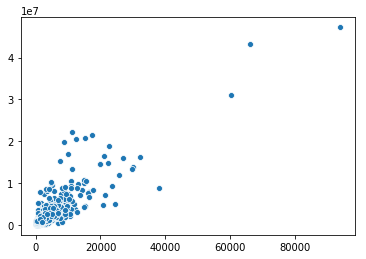

In [304]:
sns.scatterplot(X_train_ratings.sum(axis=1), y_train.values.reshape(y_train.shape[0])) 

In [309]:
np.corrcoef(X_train_ratings.sum(axis=1), y_train.values.reshape(y_train.shape[0])) 

array([[1.        , 0.86691266],
       [0.86691266, 1.        ]])

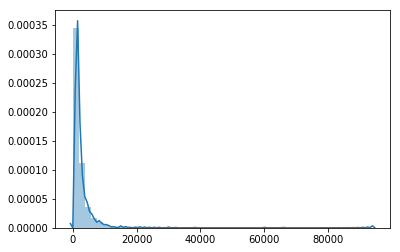

In [307]:
sns.distplot(X_train_ratings.sum(axis=1))
plt.show()

# Description, Title, Speaker Occupation

In [325]:
class EmbeddingVectorization(BaseEstimator, TransformerMixin):
        """ //TODO
        
        Parameters
        ------------
        
        Attributes
        -----------

        """
        def __init__(self, embedding_map, emb_dim, tokenizer=TweetTokenizer()):
            self.embedding_map = embedding_map
            self.emb_dim = emb_dim
            self.tokenizer = tokenizer
            
        def fit(self):
            return self
            
        def transform(self, data, column_name):
            embedding_matrix = np.zeros((data.shape[0], self.emb_dim), dtype=np.float32)
            for inx, row in enumerate(data[column_name]):
                for word in tokenizer.tokenizer(row):
                    if word in self.embedding_map:
                        embedding_matrix[inx] += self.embedding_map[word]
            return embedding_matrix